In [1]:
import numpy as np
import tensorflow as tf
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import TensorFlowV2Classifier
import matplotlib.pyplot as plt

D:\Tarun\Desktop\mlProj\my_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

In [3]:
# Preprocess data
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
y_train = tf.keras.utils.to_categorical(y_train, 100)
y_test = tf.keras.utils.to_categorical(y_test, 100)

In [4]:
# Create a simple CNN model (you can replace this with your own trained model)
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(100, activation="softmax")
])


D:\Tarun\Desktop\mlProj\my_venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [6]:
# Train the model
model.fit(x_train, y_train, epochs=10, validation_split=0.1, batch_size=64)

Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.0472 - loss: 4.2830 - val_accuracy: 0.1536 - val_loss: 3.6067
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.1759 - loss: 3.4484 - val_accuracy: 0.2140 - val_loss: 3.2433
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.2419 - loss: 3.0944 - val_accuracy: 0.2574 - val_loss: 3.0216
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.2839 - loss: 2.8793 - val_accuracy: 0.2870 - val_loss: 2.9029
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.3225 - loss: 2.6987 - val_accuracy: 0.3034 - val_loss: 2.7851
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.3490 - loss: 2.5625 - val_accuracy: 0.3222 - val_loss: 2.6942
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.3733 - loss: 2.4280 - val_accuracy: 0.3132 - val_loss: 2.7523
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.3946 - loss: 2.3317 - val_accura

In [7]:
# Define the loss function
loss_object = tf.keras.losses.CategoricalCrossentropy()

In [8]:
# Create ART classifier with loss function
classifier = TensorFlowV2Classifier(model=model, nb_classes=100, input_shape=(32, 32, 3), loss_object=loss_object)

In [9]:
# Initialize FGSM attack
attack = FastGradientMethod(estimator=classifier)

In [10]:
# Iterate over a larger range of delta values
delta_values = np.linspace(0.01, 1.0, num=100)
accuracies = []

for delta in delta_values:
    # Update the attack with the current delta value
    attack.set_params(**{'eps': delta})

    # Generate adversarial examples
    x_adv = attack.generate(x=x_test)

    # Evaluate model accuracy on adversarial examples
    accuracy = np.mean(np.argmax(classifier.predict(x_adv), axis=1) == np.argmax(y_test, axis=1))
    accuracies.append(accuracy)

In [11]:
# Identify the maximum delta value where accuracy drops below 10%
threshold_accuracy = 0.1
max_delta_fail = delta_values[np.where(np.array(accuracies) <= threshold_accuracy)[0][0]]

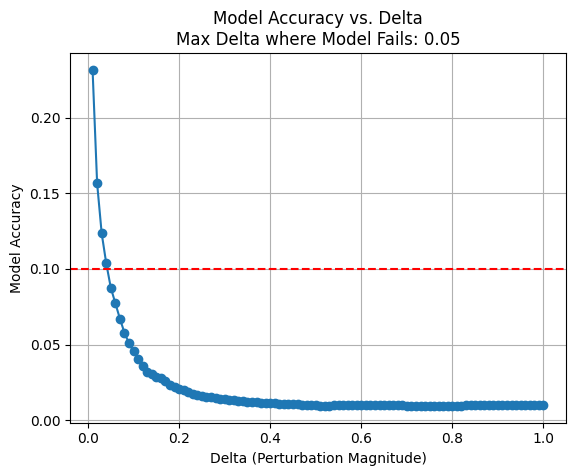

Maximum delta value after which the model fails (accuracy <= 10%): 0.05


In [12]:
# Plot the graph
plt.plot(delta_values, accuracies, marker="o")
plt.axhline(y=threshold_accuracy, color='r', linestyle='--')
plt.xlabel("Delta (Perturbation Magnitude)")
plt.ylabel("Model Accuracy")
plt.title(f"Model Accuracy vs. Delta\nMax Delta where Model Fails: {max_delta_fail:.2f}")
plt.grid(True)
plt.show()

print(f"Maximum delta value after which the model fails (accuracy <= 10%): {max_delta_fail:.2f}")